# Predicting number on the License Plate

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

### Loading pretrained Model

In [2]:
from keras.models import Sequential, load_model

In [3]:
model = load_model('cnn_classifier.h5')

### Loading image of Plate

In [4]:
import matplotlib.pyplot as plt

In [5]:
import cv2

In [6]:
img = cv2.imread('Plate.jpg')

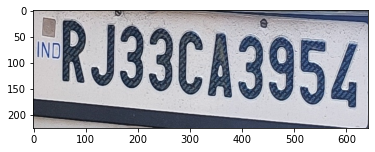

In [7]:
plt.imshow(img)

In [8]:
# BGR -> GRAY
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

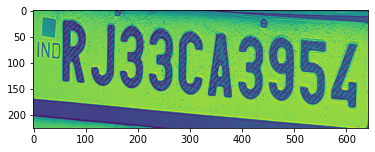

In [9]:
plt.imshow(imgray)

In [10]:
# Blurring the image
blur = cv2.GaussianBlur(imgray,(5,5),0)

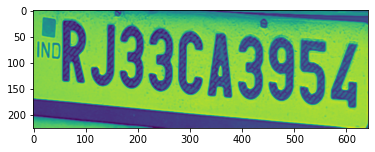

In [11]:
plt.imshow(blur)

In [12]:
# Otsu's thresholding
# For later use
ret1,th1 = cv2.threshold(imgray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

In [13]:
# Thresholding Image
ret2,th2 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

In [14]:
# Finding Contours
contours, hierarchy = cv2.findContours(th2.copy(),cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

In [15]:
# Sorting Contours
contours = sorted(contours, key=cv2.contourArea, reverse=True)

In [16]:
# Keeping contour of numbers only
cont = []
for cnts in contours:
    area = cv2.contourArea(cnts)
    if area>2100 and area<5000:
            cont.append(cnts)

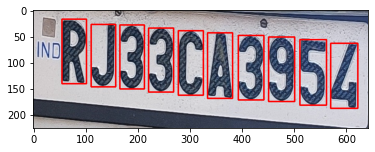

In [17]:
# Drawing Rectangle on detected numbers
i=0
for cnt in cont:
    (x,y,w,h) = cv2.boundingRect(cnt)
    cv2.rectangle(img, (x,y), (x+w,y+h), (255, 0, 0), 2)
plt.imshow(img)

### Sorting contours from left -> right

In [54]:
x_cord = []
for cnt in cont:
    (x,y,w,h) = cv2.boundingRect(cnt)
    x_cord.append(x)
x_cord = sorted(x_cord)
l2r = []
for cord in x_cord:
    for cnt in cont:
        (x,y,w,h) = cv2.boundingRect(cnt)
        if (cord == x):
            l2r.append(cnt)
            break

### Saving Segmented Image

In [18]:
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.imwrite('Segmented.jpg', img)

True

### Resizing non-square image to square image

In [21]:
import numpy as np

In [22]:
# Function
def make_square(img):
    
    h = img.shape[0]
    w = img.shape[1]

    # image after making height equal to width
    squared_image = img.copy()
    
    # In case height superior than width
    if h > w:
        diff = h-w
        if diff % 2 == 0:
            x1 = np.zeros(shape=(h, diff//2))
            x2 = x1
        else:
            x1 = np.zeros(shape=(h, diff//2))
            x2 = np.zeros(shape=(h, (diff//2)+1))

        squared_image = np.concatenate((x1, img, x2), axis=1)
        
    # In case height inferior than width
    if h < w:
        diff = w-h
        if diff % 2 == 0:
            x1 = np.zeros(shape=(diff//2, w))
            x2 = x1
        else:
            x1 = np.zeros(shape=(diff//2, w))
            x2 = np.zeros(shape=((diff//2)+1, w))

        squared_image = np.concatenate((x1, img, x2), axis=0)

    return squared_image

### Getting Cropping digits from Plate

In [58]:
digits = []
for p in l2r:
    (x,y,w,h) = cv2.boundingRect(p)
    c = th1[y:y+h,x:x+w]
    c = np.array(c)
    c = cv2.bitwise_not(c)
    c = make_square(c)
    c = cv2.resize(c,(28,28), interpolation = cv2.INTER_AREA)
    digits.append(c)

### Predicting digits

In [68]:
# Diction of all classes
alphabets_dic = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J',
             10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T',
             20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: '0', 27: '1', 28: '2', 29:'3',
             30: '4', 31: '5', 32: '6', 33: '7', 34: '8', 35: '9'}

In [78]:
for d in digits:

    d = np.reshape(d, (1,28,28,1))
    out = model.predict(d)
    # Get max pre arg
    p = []
    precision = 0
    for i in range(len(out)):
        z = np.zeros(36)
        z[np.argmax(out[i])] = 1.
        precision = max(out[i])
        p.append(z)
    prediction = np.array(p)
    key = (np.argmax(prediction))
    print (alphabets_dic[key],end="")

RJ33CA395L